# Getting started

`gallifrey` is a Python package for Bayesian structure learning, inference, and analysis within Gaussian Process models, focused on time series data. Built on JAX and using Sequential Monte Carlo (SMC) techniques, it enables efficient and flexible modeling of complex time series data. This guide will walk you through the basic steps to get started with `gallifrey`.

## Setup environment

Before importing gallifrey, we need to configure JAX to utilize all available CPU cores. This is done using the following code snippet:

In [1]:
import multiprocessing
import os

# enable jax to recognize all CPU cores
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)

In [2]:
# import necessary packages and set up plotting
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(
    context="poster",
    style="ticks",
    palette="rocket",
    font_scale=1,
    rc={
        "figure.figsize": (16, 7),
        "axes.grid": False,
        "font.family": "serif",
        "text.usetex": True,
        "lines.linewidth": 3,
    },
)

Next, import the core components from `gallifrey`:

In [3]:
from gallifrey import GPConfig, GPModel, LinearSchedule

gallifrey: Setting flag `JAX_ENABLE_X64` to `True`
gallifrey: Setting flag `OMP_NUM_THREADS` to `1`


## Generate mock data

For this quickstart, we'll generate some mock data for demonstration. We create a simple data set, and reserve some data for training and testing.

In [4]:
rng_key = jr.PRNGKey(0)

In [5]:
# Mock data
key, data_key = jr.split(rng_key)
n = 160
noise_var = 9.0
x = jnp.linspace(0, 15, n)
y = (x + 0.01) * jnp.sin(x * 3.2) + jnp.sqrt(noise_var) * jr.normal(data_key, (n,))


# mask values
xtrain = x[(x < 10)]
ytrain = y[(x < 10)]

## Initialize the GP Model

Now we can initialize the Gaussian Process model. There are a variety of setting for the details of the model, but for this quickstart we can stick with the default config. Please see the tutorials for more details on the different options. We also have to set the number of particles, which together form an ensemble of Gaussian Processes used to make predictions.

In [6]:
config = GPConfig()

key, model_key = jr.split(key)
gpmodel = GPModel(
    model_key,
    x=xtrain,
    y=ytrain,
    num_particles=8,
    config=config,
)

## Fit the GP Model using SMC

And now we can fit the GP model to the data. We use a Sequential Monte Carlo sampling with a data annealing schedule.

In [7]:
key, smc_key = jr.split(key)
final_smc_state, history = gpmodel.fit_smc(
    smc_key,
    annealing_schedule=LinearSchedule().generate(len(xtrain), 10),
    n_mcmc=75,
    n_hmc=10,
    verbosity=1,
)
gpmodel = gpmodel.update_state(final_smc_state)

Running SMC round [1/10] with [1/106] data points.
Weights: [0.05392501 0.10727033 0.23023163 0.07581755 0.09684554 0.17955717
 0.16175602 0.09459675]
Resampled: False (Normalised ESS: 0.83)
Particle 1 | Accepted: MCMC[49/75]  HMC[490/490]
Particle 2 | Accepted: MCMC[45/75]  HMC[450/450]
Particle 3 | Accepted: MCMC[51/75]  HMC[510/510]
Particle 4 | Accepted: MCMC[51/75]  HMC[510/510]
Particle 5 | Accepted: MCMC[48/75]  HMC[480/480]
Particle 6 | Accepted: MCMC[54/75]  HMC[540/540]
Particle 7 | Accepted: MCMC[57/75]  HMC[570/570]
Particle 8 | Accepted: MCMC[62/75]  HMC[620/620]
Running SMC round [2/10] with [13/106] data points.
Weights: [8.05914360e-04 5.47702896e-06 3.93273140e-07 1.17978333e-02
 6.02643432e-01 6.84271626e-05 3.84672447e-01 6.07536689e-06]
Resampled: True (Normalised ESS: 0.24)
Particle 1 | Accepted: MCMC[48/75]  HMC[479/480]
Particle 2 | Accepted: MCMC[36/75]  HMC[360/360]
Particle 3 | Accepted: MCMC[46/75]  HMC[460/460]
Particle 4 | Accepted: MCMC[46/75]  HMC[460/460

## Predictions using the model

With the fitted model, we can now make predictions. Since the SMC sampler fits an entire ensemble of Gaussian processes, we can use the mixture of predictive distributions for our forecasting.

In [8]:
xtest = gpmodel.x_transform(jnp.linspace(0, 20, 500))
dist = gpmodel.get_mixture_distribution(xtest)

predictive_mean = dist.mean()
predictive_std = dist.stddev()

<Axes: >

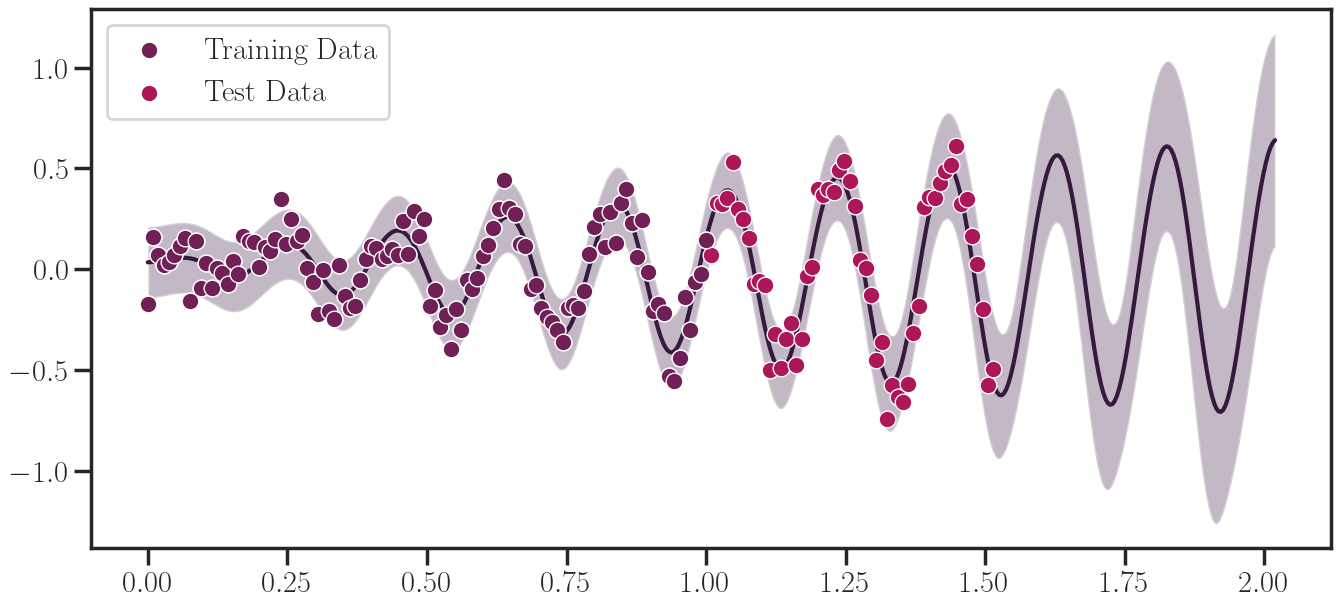

In [9]:
plot = sns.lineplot(x=xtest, y=predictive_mean)
plot.fill_between(
    xtest,
    predictive_mean - predictive_std,
    predictive_mean + predictive_std,
    alpha=0.3,
)

sns.scatterplot(
    x=gpmodel.x_transformed,
    y=gpmodel.y_transformed,
    label="Training Data",
    ax=plot,
    zorder=3,
)
sns.scatterplot(
    x=gpmodel.x_transform(x),
    y=gpmodel.y_transform(y),
    label="Test Data",
    ax=plot,
    zorder=2,
)

Alternatively, we can look that the prediction from each particle individually.

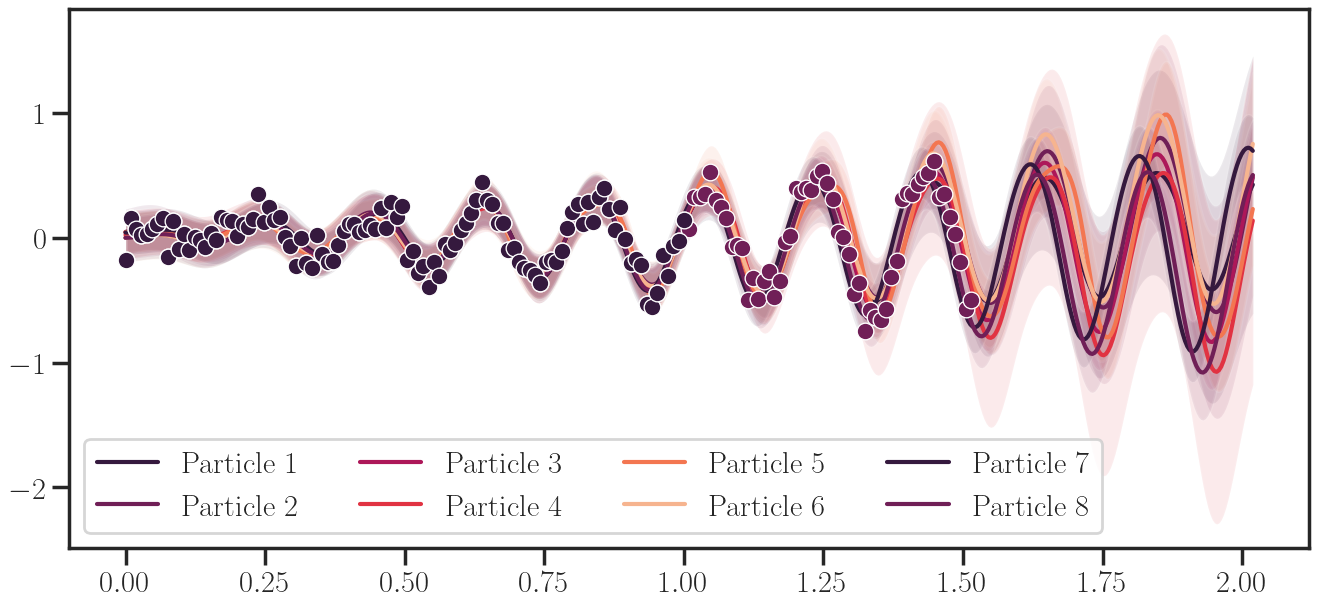

In [10]:
dist = gpmodel.get_predictive_distributions(xtest)

means, stds = [], []
for d in dist:
    means.append(d.mean())
    stds.append(d.stddev())

fig, ax = plt.subplots()
for i in range(len(means)):
    sns.lineplot(x=xtest, y=means[i], label=f"Particle {i+1}", ax=ax)
    ax.fill_between(
        xtest,
        means[i] - stds[i],
        means[i] + stds[i],
        alpha=0.1,
    )

sns.scatterplot(
    x=gpmodel.x_transformed,
    y=gpmodel.y_transformed,
    ax=ax,
    zorder=3,
    color="C0",
)
sns.scatterplot(
    x=gpmodel.x_transform(x),
    y=gpmodel.y_transform(y),
    ax=ax,
    zorder=2,
    color="C1",
)
ax.legend(ncols=4)

## Conclusion

And we're done! This quickstart guide provides a minimal example to get you started. For more advanced features, customization options, and detailed explanations, please refer to the tutorials and full documentation.

